In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
rcParams['axes.titlesize'] = 'xx-large'
rcParams['axes.titleweight'] = 'bold'
rcParams["legend.loc"] = 'upper left'

Using TensorFlow backend.


In [ ]:
# Take in dataset and graph for reference
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('http://kdl.cs.umb.edu/CS670/data/Ganges_1996_2016.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
data = data.astype('float64')


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


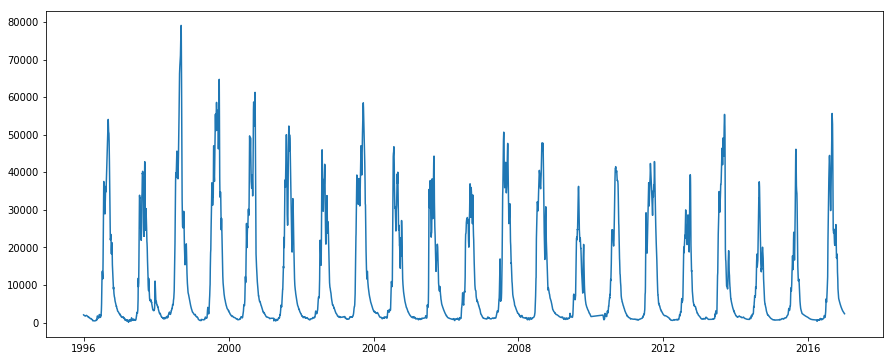

In [ ]:
data.fillna(method='ffill', inplace=True)
plt.plot(data)

In [ ]:
# Split data sets
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence.iloc[i:end_ix].values, sequence.iloc[end_ix].values
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
# Split data sets and check shape
n_steps = 20
X, y = split_sequence(data, n_steps)
  
# Split into test, validation, and training
#train_split = 5094
train_split = 5010
#valid_split = 5824
valid_split = 5740

X_train, y_train = X[:train_split],y[:train_split]
X_valid, y_valid = X[train_split:valid_split],y[train_split:valid_split]
X_test, y_test = X[valid_split:],y[valid_split:]

In [ ]:
from keras.layers import Dropout
cnn = Sequential()
cnn.add(Conv1D(filters = 64,kernel_size = 2, activation = 'relu',input_shape = (n_steps,1)))
#cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(35,activation='relu'))
cnn.add(Dropout(0.1))
cnn.add(Dense(1))
cnn.compile(optimizer='adam',loss='mse')
cnn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 19, 64)            192       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 35)                42595     
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 36        
Total params: 42,823
Trainable params: 42,823
Non-trainable params: 0
_________________

In [ ]:
history = cnn.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs=50, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 5010 samples, validate on 730 samples
Epoch 1/50
5010/5010 [==============================] - 1s 236us/step - loss: 25883418.0091 - val_loss: 1986092.3232
Epoch 2/50
5010/5010 [==============================] - 0s 85us/step - loss: 7633820.5309 - val_loss: 1075660.8986
Epoch 3/50
5010/5010 [==============================] - 0s 84us/step - loss: 6067193.7563 - val_loss: 2858688.2147
Epoch 4/50
5010/5010 [==============================] - 0s 85us/step - loss: 5707122.1505 - val_loss: 649369.2574
Epoch 5/50
5010/5010 [==============================] - 0s 83us/step - loss: 5506048.5541 - val_loss: 2152714.2091
Epoch 6/50
5010/5010 [==============================] - 0s 84us/step - loss: 5649637.0251 - val_loss: 1319733.1135
Epoch 7/50
5010/5010 [==============================] - 0s 91us/step - loss: 4990178.1619 - val_loss: 1334063.0486
Epoch 8/50
5010/5010 [==============================] - 0s 84us/step - loss: 5339373.9051 - val_los

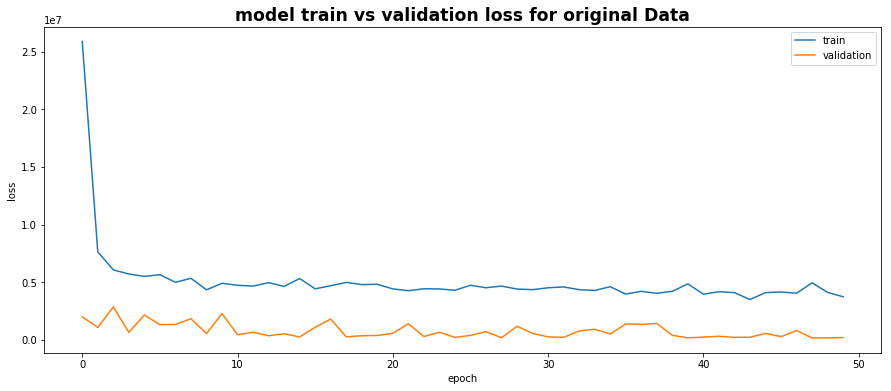

In [ ]:
# Task 2 Plot LSTM for original Data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss for original Data')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [ ]:
# make predictions
predict = cnn.predict(X_test)
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(y_test, predict))
print('Test Score CNN: %.2f RMSE' % (testScore))

Test Score CNN: 580.49 RMSE


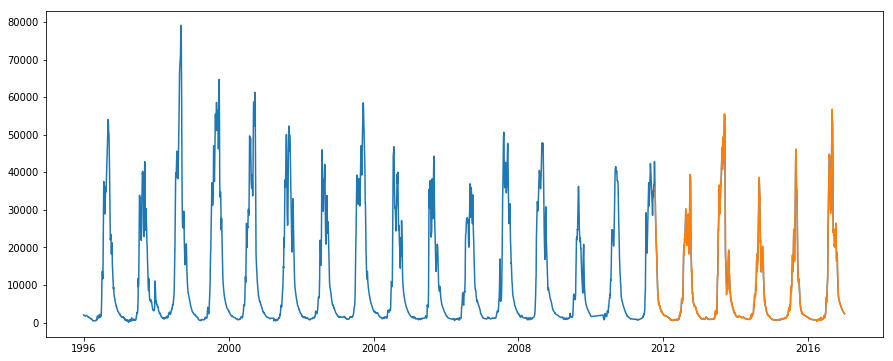

In [ ]:
# Show predictions vs ground truth values for CNN
predict_plot = pd.DataFrame(predict, data.index[valid_split+n_steps:])
plt.plot(data)
plt.plot(predict_plot)
plt.show()

In [ ]:
periods = 5
ts_dif = data - data.shift(periods=periods)
#ts_dif.dropna(inplace=True)
ts_dif.fillna(method='ffill', inplace=True)

# Split data sets and check shape
n_steps = 20
X_dif, y_dif = split_sequence(ts_dif, n_steps)
  
# Split into test, validation, and training
train_split_dif = 5015 - periods
valid_split_dif = 5745 - periods
X_train_dif, y_train_dif = X_dif[:train_split_dif],y_dif[:train_split_dif]
X_valid_dif, y_valid_dif = X_dif[train_split_dif:valid_split_dif],y_dif[train_split_dif:valid_split_dif]
X_test_dif, y_test_dif = X_dif[valid_split_dif:],y_dif[valid_split_dif:]

cnn_dif = Sequential()
cnn_dif.add(Conv1D(filters = 64,kernel_size = 2, activation = 'relu',input_shape = (n_steps,1)))
cnn_dif.add(MaxPooling1D(pool_size=2))
cnn_dif.add(Flatten())
cnn_dif.add(Dense(15,activation='relu'))
cnn_dif.add(Dropout(0.1))
cnn_dif.add(Dense(1))
cnn_dif.compile(optimizer='adam',loss='mse')
cnn_dif.summary()
cnn_dif.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs=90, verbose=1)

predict_dif = cnn_dif.predict(X_test_dif)

# invert differenced value
def inverse_diff(pred, periods):
  prediction = []
  vs = valid_split
  for i in range(len(pred)):
    hist = data.values[:vs]
    p = pred[i] + hist[-periods]
    prediction.append(p)
    vs = vs+1
  return prediction
#inverse differnce predictions and plot
history_r = [x for x in data.values][:valid_split]


predict_invdif = inverse_diff(predict_dif, periods)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 19, 64)            192       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                8655      
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 16        
Total params: 8,863
Trainable params: 8,863
Non-trainable params: 0
_________________________________________________________________
Train on

In [ ]:
# calculate root mean squared error
testScore_dif = math.sqrt(mean_squared_error(y_test, predict_invdif))
print('Test Score CNN: %.2f RMSE' % (testScore_dif))

Test Score CNN: 9085.57 RMSE


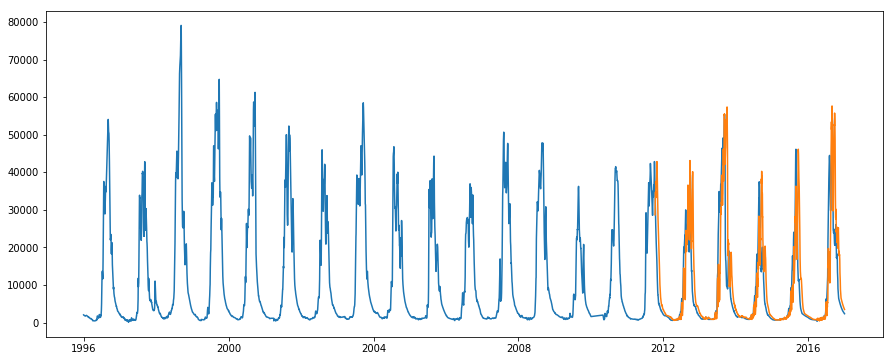

In [ ]:
# Show predictions vs ground truth values for CNN
predict_plot2 = pd.DataFrame(predict_invdif, data.index[valid_split+n_steps:])
plt.plot(data)
plt.plot(predict_plot2)
plt.show()